#  Project

**Project Goal:** 

**Dataset Period:**

**Methodology:** 

---

## 1. Business Understanding

### 1.1 Business Objectives
TODO

### 1.2 Project Goals and Successs Criteria
TODO


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

---
## 2. Data Understanding

### 2.1 Data Collection

The first step is to load the datasets into the working environment. This involves importing the necessary libraries and reading the data file into a suitable data structure, namely, a DataFrame using Pandas.

In [57]:
# Load datasets
weather = pd.read_csv("weather.csv", parse_dates=["time"])
energy = pd.read_csv("energy_dataset.csv", parse_dates=["time"])

# Set 'time' as index
weather = weather.set_index("time")
energy = energy.set_index("time")

### 2.2 Data Description

##### Basic dataset information

In [58]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35045 non-null  float64
 1   generation_fossil_brown_coal_lignite         35046 non-null  float64
 2   generation_fossil_coal-derived_gas           35046 non-null  float64
 3   generation_fossil_gas                        35046 non-null  float64
 4   generation_fossil_hard_coal                  35046 non-null  float64
 5   generation_fossil_oil                        35045 non-null  float64
 6   generation_fossil_oil_shale                  35046 non-null  float64
 7   generation_fossil_peat                       35046 non-null  float64
 8   generation_geothermal                        35046 non-null  float64
 9   generation_hydro_pumped_storage_a

The *energy* dataset contains 35064 entries and 24 features, representing hourly records of electricity generation from various sources, total system load, and the day-ahead market price. Each row corresponds to one hour of energy system operation, and the goal is to forecast the electricity price one hour and one day ahead.

In [59]:
energy.describe()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,...,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,0.0,35028.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,NaN,28696.939905,49.874341
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,NaN,4574.987950,14.618900
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,18041.000000,2.060000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,NaN,24807.750000,41.490000
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,NaN,28901.000000,50.520000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,NaN,32192.000000,60.530000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,NaN,41015.000000,101.990000


In [60]:
energy.head()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,...,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,NaN,25385.0,50.10
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,NaN,24382.0,48.10
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,NaN,22734.0,47.33
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,NaN,21286.0,42.27
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,NaN,20264.0,38.41


In [61]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  35064 non-null  float64
 1   pressure     35064 non-null  float64
 2   humidity     35064 non-null  float64
 3   wind_speed   35064 non-null  float64
dtypes: float64(4)
memory usage: 1.3+ MB


The *weather* dataset also contains 35064 entries and 5 features representing hourly meteorological measurements such as temperature, pressure, humidity, and wind speed. Each row corresponds to one hour of weather conditions, and these variables are used as exogenous inputs to improve electricity price forecasting.

In [62]:
weather.describe()

,temperature,pressure,humidity,wind_speed
count,35064.000000,35064.000000,35064.000000,35064.000000
mean,289.706862,1017.297872,68.033025,2.442944
std,7.251796,6.363845,14.814871,1.276415
min,272.006000,999.500000,22.600000,0.000000
25%,284.098877,1013.475000,56.750000,1.400000
50%,289.036200,1017.000000,69.600000,2.200000
75%,295.100500,1021.000000,80.000000,3.200000
max,309.048000,1035.500000,100.000000,8.500000


In [63]:
weather.head()

,temperature,pressure,humidity,wind_speed
time,,,,
2015-01-01 00:00:00+01:00,272.491463,1021.3,82.4,2.0
2015-01-01 01:00:00+01:00,272.512700,1021.2,82.4,2.0
2015-01-01 02:00:00+01:00,272.151937,1021.6,82.0,2.4
2015-01-01 03:00:00+01:00,272.142269,1021.5,82.0,2.4
2015-01-01 04:00:00+01:00,272.198700,1021.5,82.0,2.4


### 2.3 Data Exploration

#### 2.3.1 Target variable analysis

The target variable `price_day_ahead` represents the eletricity market price for the upcoming hour.

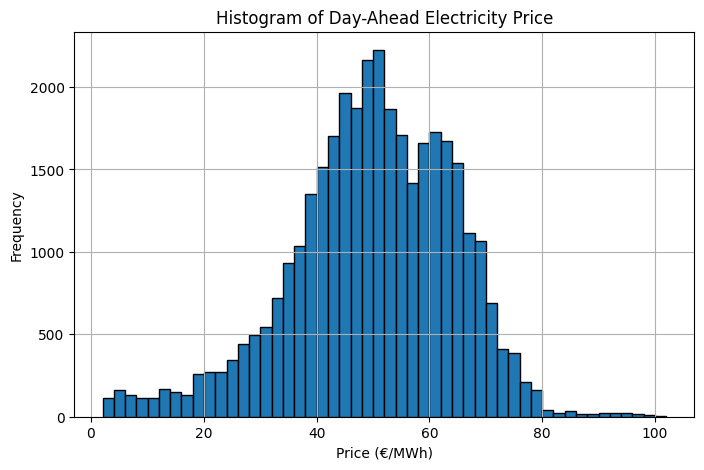

In [64]:
plt.figure(figsize=(8,5))
plt.hist(energy['price_day_ahead'], bins=50, edgecolor='black')
plt.title("Histogram of Day-Ahead Electricity Price")
plt.xlabel("Price (€/MWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram shows a distribution that is very close to a normal distribution, although it is slightly right-skewed.

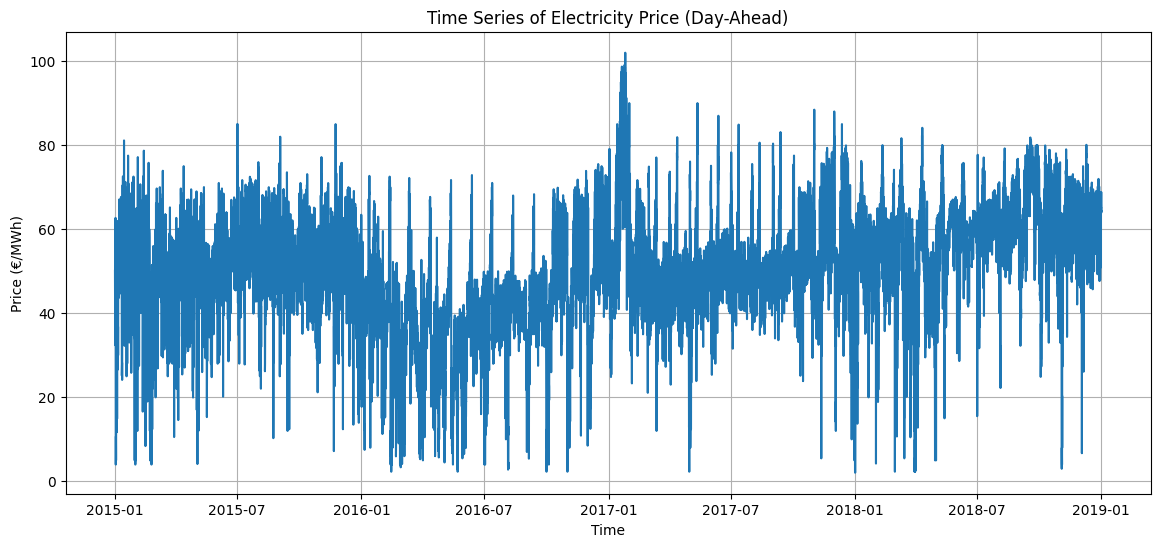

In [65]:
plt.figure(figsize=(14, 6))
plt.plot(energy['price_day_ahead'])
plt.title("Time Series of Electricity Price (Day-Ahead)")
plt.xlabel("Time")
plt.ylabel("Price (€/MWh)")
plt.grid(True)
plt.show()

The time series plot shows strong short-term fluctuations and clear seasonal patterns, with occasional price spikes. Prices vary over time, indicating non-stationarity and the presence of both volatility and periodic behavior.

#### 2.3.2 Feature distribution analysis

Now we will perform feature distribution analysis to examine how the data values are spread across the datasets. We will use plots and histograms to visualise the distributions features. Box plots for will be skipped in this step, as they will be specifically used for outlier detection in paragraph `2.4.2`.

In [66]:
def feat_distribution(nonDiscreteFeatures, df):
    nrows = math.ceil(len(nonDiscreteFeatures) / 2)
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
    axes = axes.flatten()

    for i, col in enumerate(nonDiscreteFeatures):
        df[col].hist(bins=30, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.show()

All of the features are numerical and continuous.

##### Energy dataset

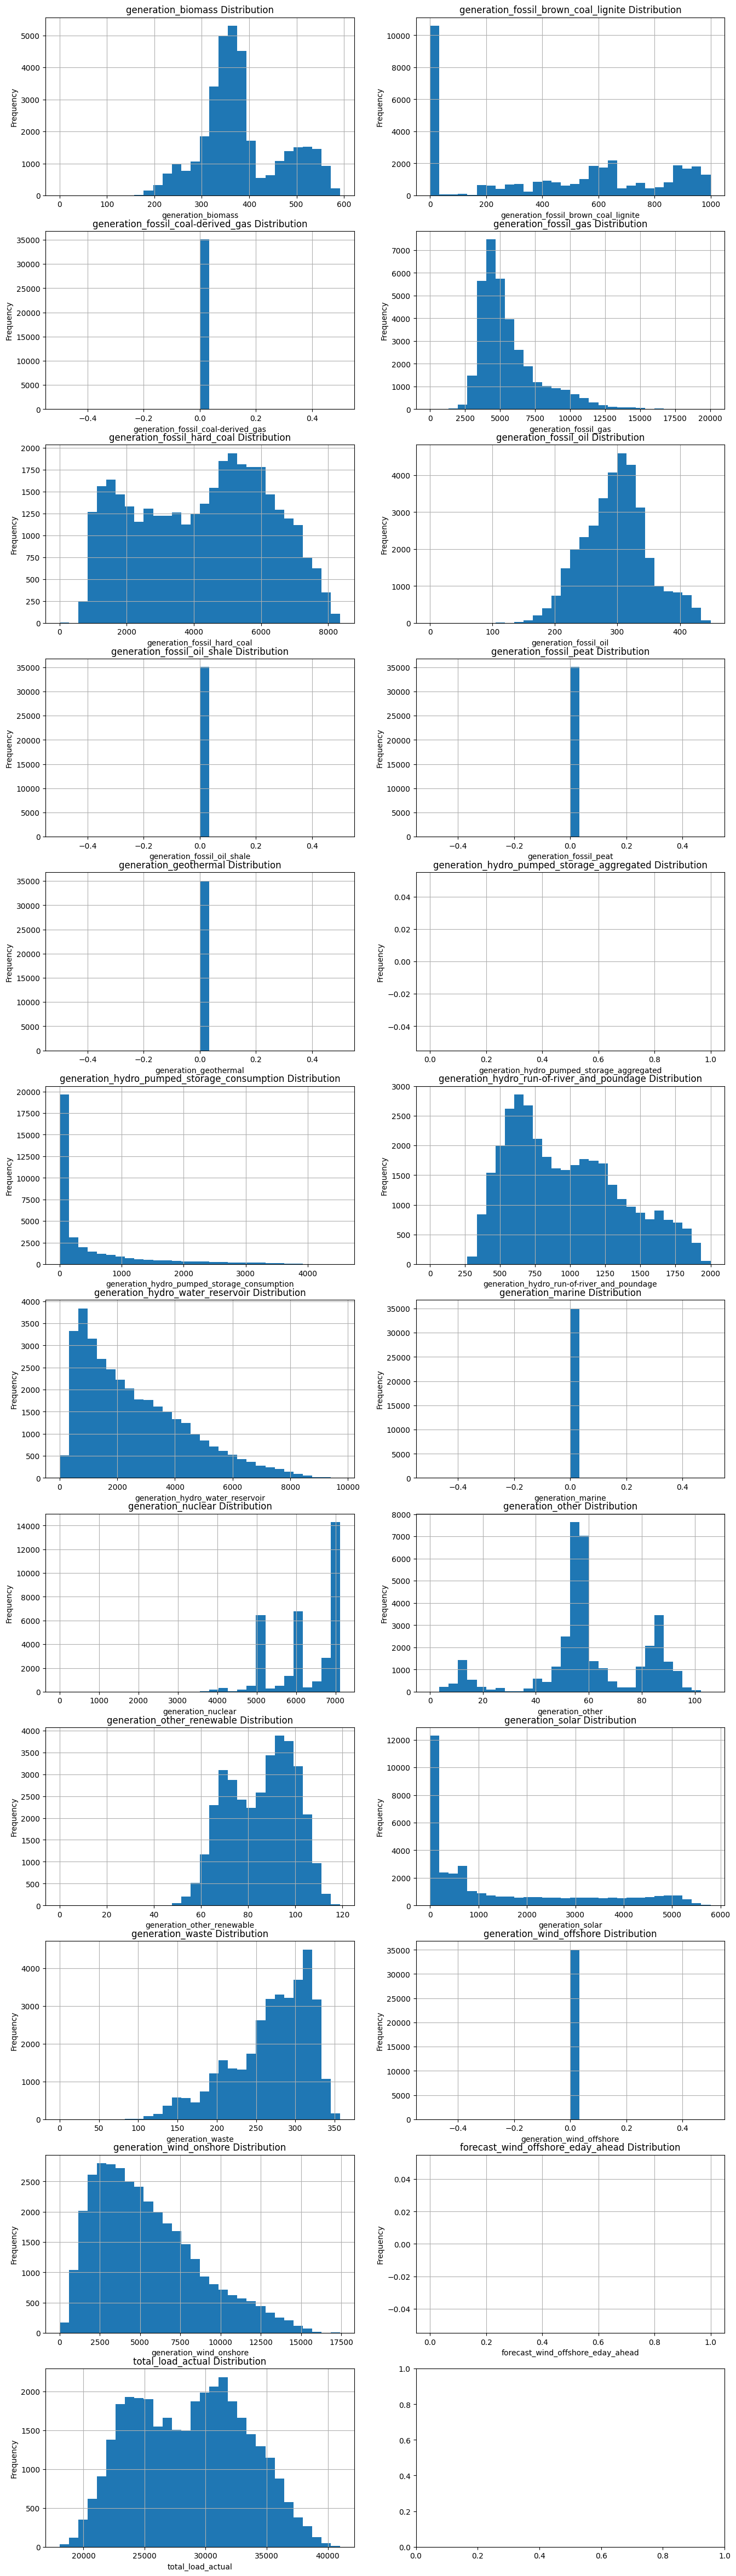

In [67]:
energy_features = [col for col in energy.columns 
                   if col not in ['time', 'price_day_ahead']]
feat_distribution(energy_features, energy)

None of the features has a normal distribution. `generation_hydro_pumped_storage_consumption`, `generation_hydro_water_reservoir`, and `generation_solar` are strongly right-skewed, while `generation_wind_onshore` is moderately right-skewed. In contrast, `generation_waste` is left-skewed.
Variables with skewed distributions will be handled in paragraph 3.4.3, because skewness can negatively affect the models used later in paragraph 4.2, particularly KNN, SVR, and Linear Regression, which rely on distance metrics or assumptions of linearity.

`generation_marine`, `generation_geothermal`, `generation_fossil_oil_shale`, `generation_fossil_peat`, and `generation_fossil_coal-derived_gas` contain only zeros, which is consistent with the dataset description provided in paragraph 2.2.

The data represented by the remaining variables generally show irregular, multimodal, or heavily skewed shapes, reflecting the diverse and highly variable nature of electricity generation across different sources.

In [68]:
skewed_cols = ['generation_hydro_pumped_storage_consumption','generation_hydro_water_reservoir','generation_solar','generation_wind_onshore','generation_waste']

##### Weather dataset

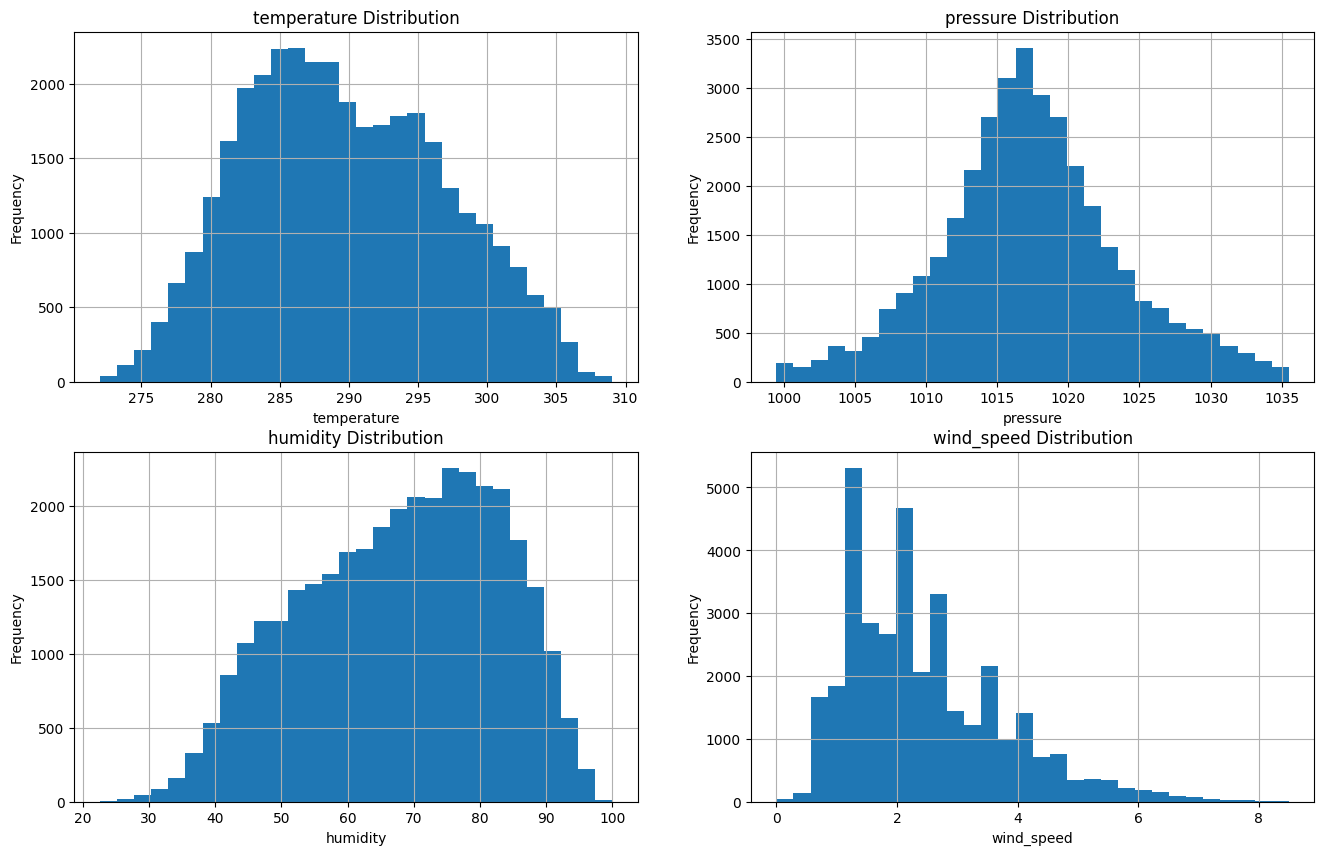

In [69]:
weather_features = [col for col in weather.columns if col != 'time']
feat_distribution(weather_features, weather)

`temperature` and `pressure` distribution is close to normal, whereas `humidity` is slightly left-skewed and `wind_speed` is right-skewed.

Skeweness will be handled in paragraph DOK

### 2.4 Data Quality Assessment

#### 2.4.1 Identify missing values

In the first place, we will check for missing values to ensure data completeness and avoid potential issues during analysis and modeling.

In [70]:
# % missing values by column

def missing_values_info(df):
    nulls = df.isnull().sum()
    percent = round(nulls / df.shape[0] * 100, 3)
    
    nullvalues = pd.concat([nulls, percent], axis=1)
    nullvalues.columns = ["Count", "%"]
    
    return nullvalues


In [71]:
missing_values_info(energy)

,Count,%
generation_biomass,19,0.054
generation_fossil_brown_coal_lignite,18,0.051
generation_fossil_coal-derived_gas,18,0.051
generation_fossil_gas,18,0.051
generation_fossil_hard_coal,18,0.051
generation_fossil_oil,19,0.054
generation_fossil_oil_shale,18,0.051
generation_fossil_peat,18,0.051
generation_geothermal,18,0.051
generation_hydro_pumped_storage_aggregated,35064,100.000


The proportion of missing values varies across the energy-generation features. Most variables contain only a very small fraction of missing entries (around 0.05% each), including `generation_biomass`, `generation_fossil_gas`, `generation_solar`, `generation_wind_onshore`, and many others.
A few features have slightly higher but still low missing rates, such as `generation_nuclear` at 0.048% and `total_load_actual` at 0.103%.

Two variables — `generation_hydro_pumped_storage_aggregated` and `forecast_wind_offshore_eday_ahead` — have 100% missing values, meaning they contain no usable data.

In [72]:
# skipping the NaNs
energy_features = [
    f for f in energy_features
    if energy[f].notna().sum() > 0
]

In [73]:
missing_values_info(weather)

,Count,%
temperature,0,0.0
pressure,0,0.0
humidity,0,0.0
wind_speed,0,0.0


There are no missing values in `weather` dataset.

#### 2.4.2 Identify outliers

Based on dataframes information in paragraph `2.2` there might be potential outliers such as values at the extreme ends of the distributions (e.g., very high generation levels or unusually low/high prices). These points can disproportionately influence analysis and model results. That's why now we will identify outliers.

##### 2.4.2.1 Target variable

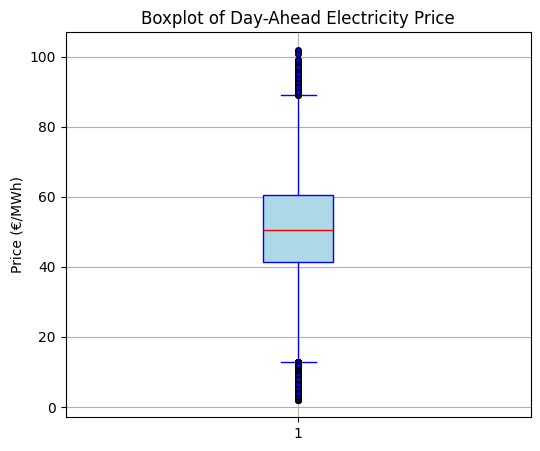

In [74]:
plt.figure(figsize=(6,5))
plt.boxplot(
    energy['price_day_ahead'],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='blue')
)
plt.title("Boxplot of Day-Ahead Electricity Price")
plt.ylabel("Price (€/MWh)")
plt.grid(True)
plt.show()


The boxplot shows clear price spikes, confirming the presence of outliers in the target variable. These extreme values reflect real market volatility but may negatively affect several forecasting models. Therefore, while they are kept in the dataset, they will be handled later in paragraph `3.4.3` DOK through appropriate preprocessing to minimise their impact on model performance.

##### 2.4.2.2 Energy features

In [75]:
def boxplots(numeric_features, df):
    num_plots = len(numeric_features)
    cols = 2
    rows = math.ceil(num_plots / cols)

    plt.figure(figsize=(cols * 5, rows * 4))

    for i, feature in enumerate(numeric_features):
        plt.subplot(rows, cols, i + 1)
        sns.boxplot(y=df[feature])
        plt.title(f"Boxplot: {feature}")

    plt.tight_layout()
    plt.show()

def outliers_detection(numericFeatures, df):
    Q1 = df[numericFeatures].quantile(0.25)
    Q3 = df[numericFeatures].quantile(0.75)
    IQR = Q3 - Q1

    outliers = ((df[numericFeatures] < (Q1 - 1.5 * IQR)) | (df[numericFeatures] > (Q3 + 1.5 * IQR)))
    print("Number of outliers per numeric feature:")
    print(outliers.sum())

    outliers_cols = outliers.any()
    outliers_cols = outliers_cols[outliers_cols].index.tolist()
    print("\nColumns containing outliers:")
    print(outliers_cols)


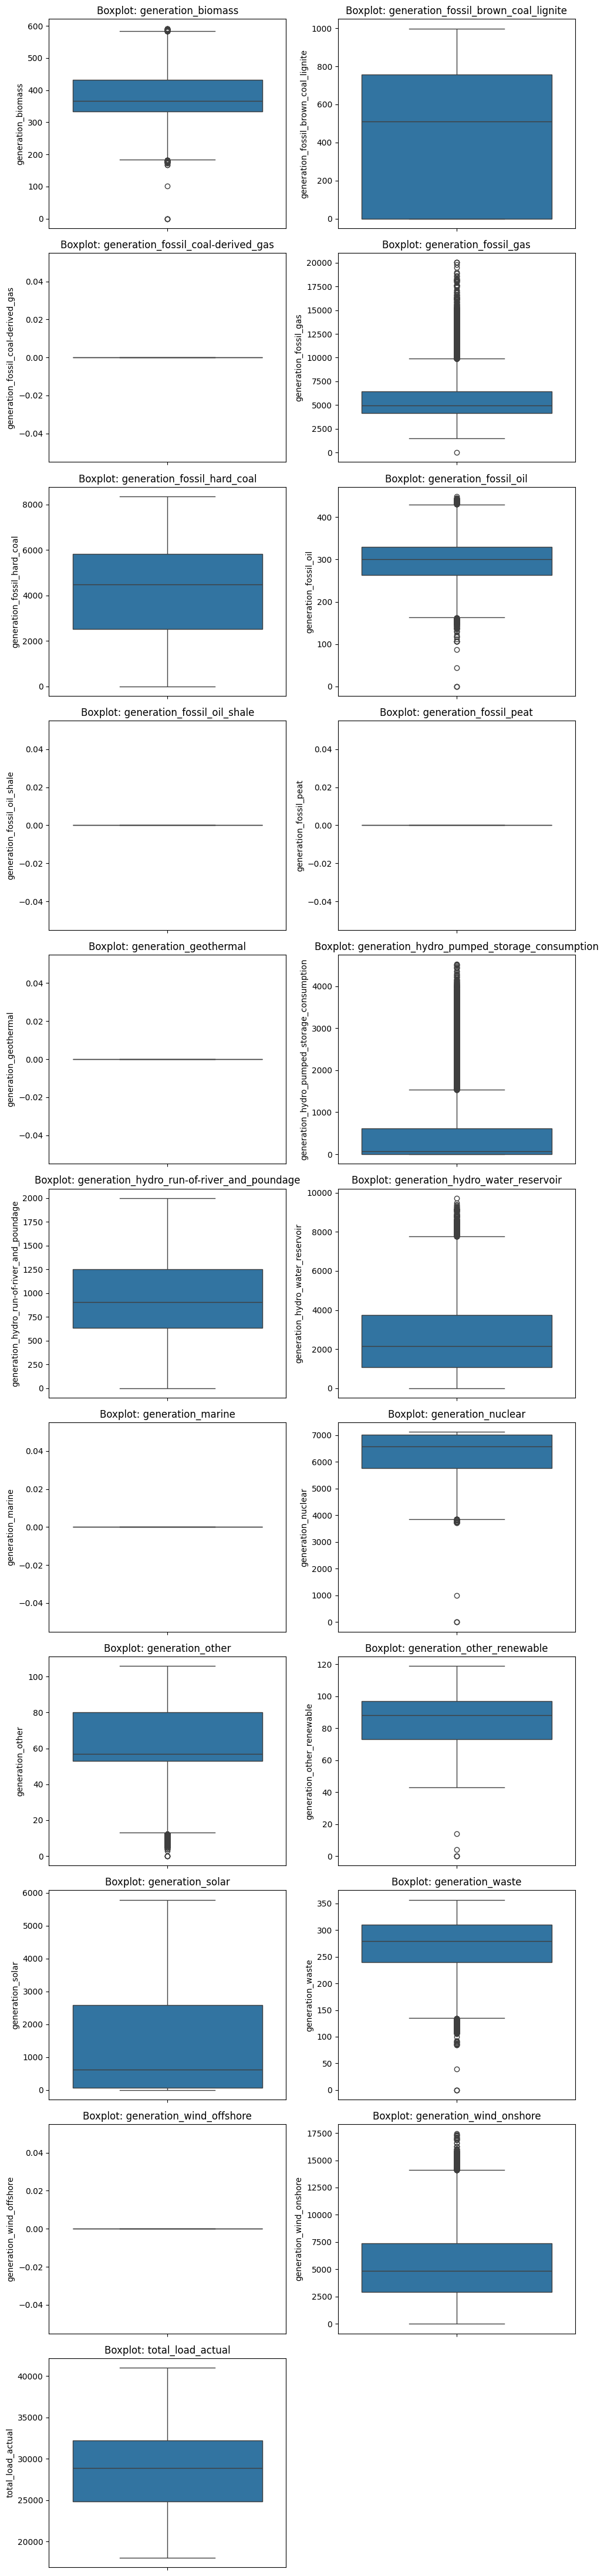

Number of outliers per numeric feature:
generation_biomass                               87
generation_fossil_brown_coal_lignite              0
generation_fossil_coal-derived_gas                0
generation_fossil_gas                          2185
generation_fossil_hard_coal                       0
generation_fossil_oil                           246
generation_fossil_oil_shale                       0
generation_fossil_peat                            0
generation_geothermal                             0
generation_hydro_pumped_storage_consumption    3762
generation_hydro_run-of-river_and_poundage        0
generation_hydro_water_reservoir                343
generation_marine                                 0
generation_nuclear                               74
generation_other                               1267
generation_other_renewable                        5
generation_solar                                  0
generation_waste                                328
generation_wind_offshore

In [76]:
boxplots(energy_features, energy)
outliers_detection(energy_features, energy)

We performed outliers detection on all numerical features using the Interquartile Range (IQR) method and visualized it using boxplots.

Features such as `generation_fossil_gas`, `generation_hydro_pumped_storage_consumption` and `generation_other` contain a high number of outlier values.
`generation_wind_onshore`, `generation_waste`,`generation_hydro_water_reservoir` and `generation_fossil_oil` alco contained a noticeable number out outliers.
`generation_biomass` contains a few outliers.
The rest of the features of `energy` dataset showed no outliers according to the IQR method.

##### 2.4.2.3 Weather features

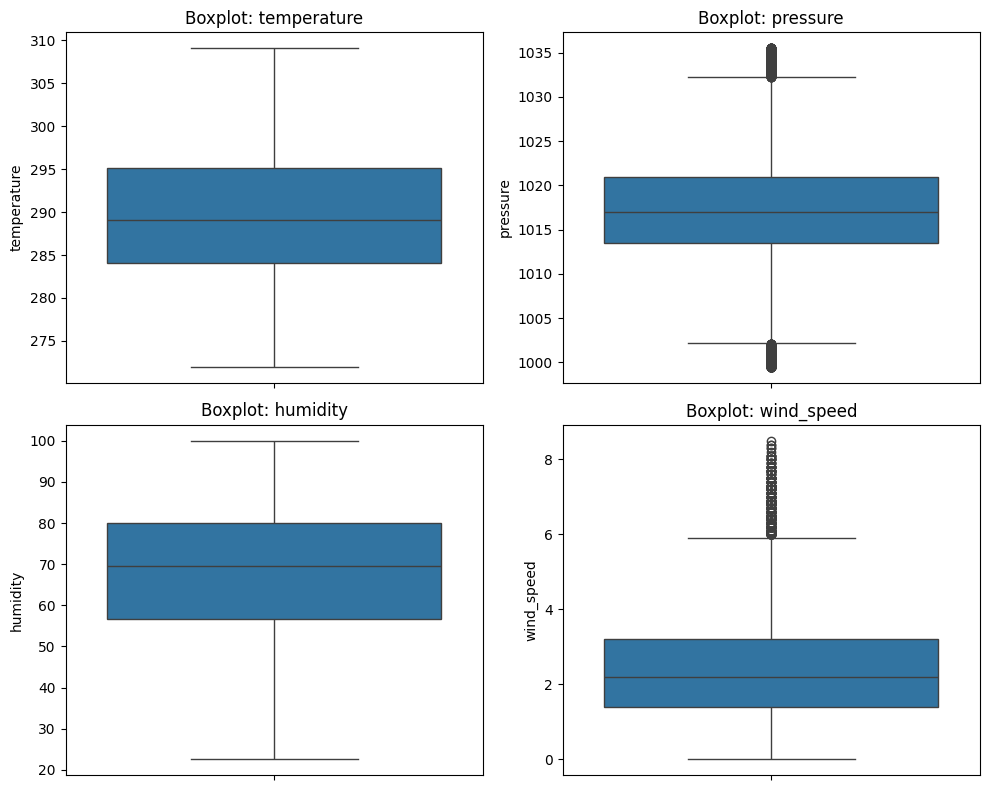

Number of outliers per numeric feature:
temperature      0
pressure       915
humidity         0
wind_speed     600
dtype: int64

Columns containing outliers:
['pressure', 'wind_speed']


In [77]:
boxplots(weather_features, weather)
outliers_detection(weather_features, weather)

`pressure` and `wind_speed` contain a noticeable number of outliers.

#### 2.4.3 Check data duplication

In [78]:
energy.duplicated().sum()

np.int64(1)

In [79]:
weather.duplicated().sum()

np.int64(592)

---
## 3. Data Preparation

### 3.1 Data Cleaning

#### 3.1.1 Missing values

The first thing to be perfomed is to handle missing values indicated in paragraph `2.4.1`.

The missing values cannot be romoved that's why the NaNs will be filled in and columns only with NaNs will be dropped.

In [83]:
print("Remaining NaNs in energy:", energy.isna().sum().sum())
print("Remaining NaNs in weather:", weather.isna().sum().sum())

# Drop columns that contain only NaN values
energy = energy.dropna(axis=1, how='all')
weather = weather.dropna(axis=1, how='all')

# Interpolate missing values (time-series aware)
energy.index = pd.to_datetime(energy.index, errors='coerce', utc=True)
weather.index = pd.to_datetime(weather.index, errors='coerce', utc=True)
energy = energy.interpolate(method='time')
weather = weather.interpolate(method='time')

# Forward-fill remaining NaNs (edge cases)
energy = energy.ffill().bfill()
weather = weather.ffill().bfill()

print("Remaining NaNs in energy:", energy.isna().sum().sum())
print("Remaining NaNs in weather:", weather.isna().sum().sum())


Remaining NaNs in energy: 0
Remaining NaNs in weather: 0
Remaining NaNs in energy: 0
Remaining NaNs in weather: 0


#### 3.1.2 Handling outliers

TODO

### 3.2 Bivariate analysis

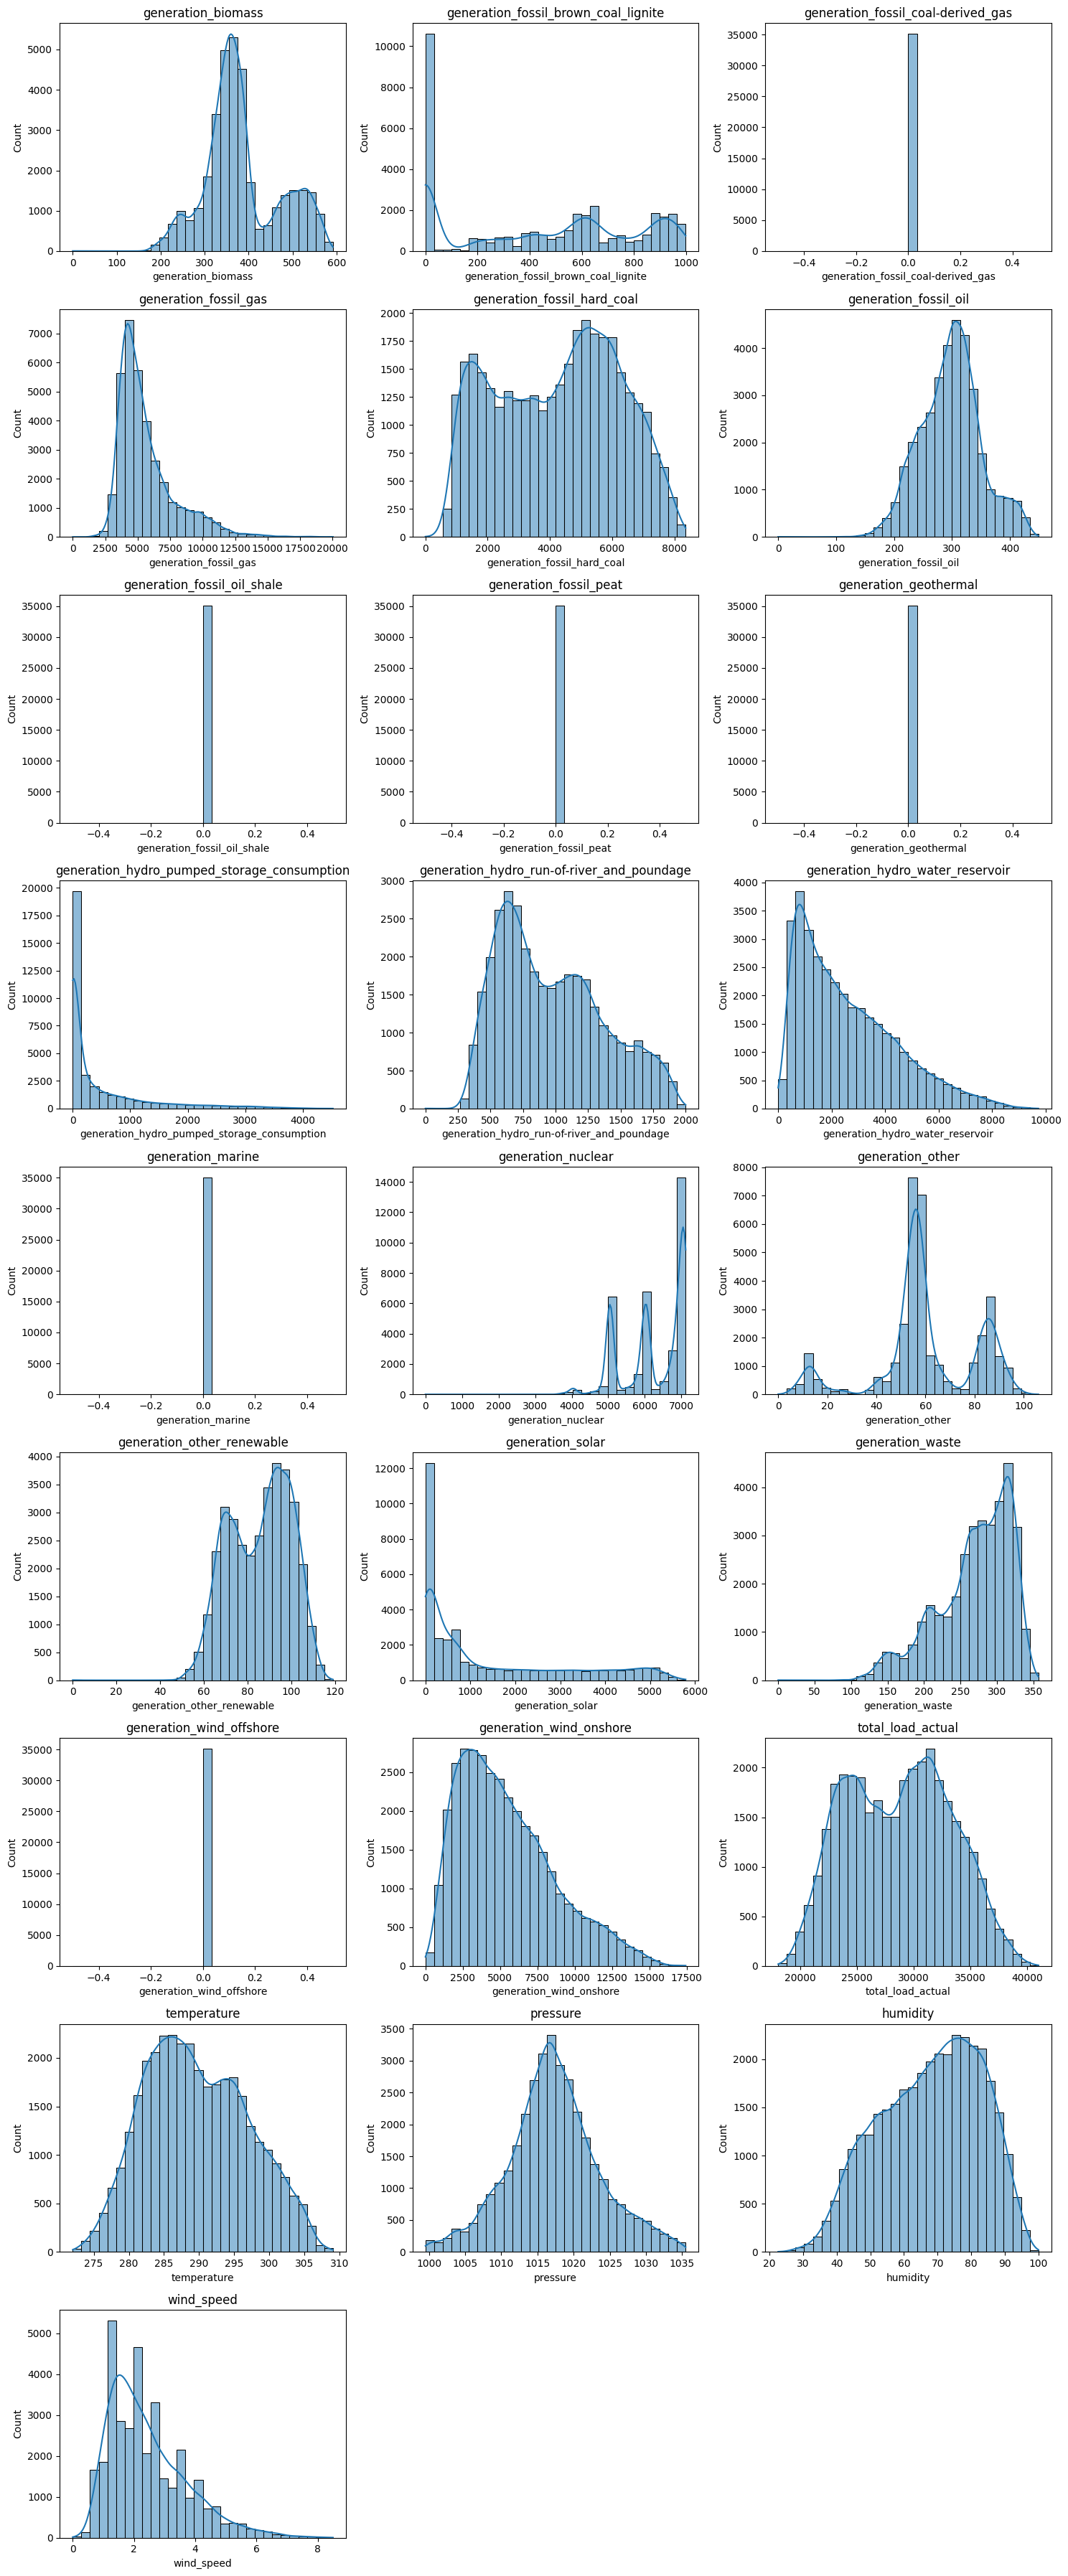

In [84]:
df_analysis = energy.join(weather, how="inner")
features = df_analysis.select_dtypes(include="number").drop(columns=["price_day_ahead"])

import matplotlib.pyplot as plt
import seaborn as sns
import math

num_features = len(features.columns)
cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(features.columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_analysis[feature], kde=True, bins=30)
    plt.title(feature)

plt.tight_layout()
plt.show()


#### Correlation between the eletricity price and the day of the week

In [ ]:
print(type(energy.index))
print(energy.index[:5])

weekday_price = energy['price_day_ahead'].groupby(energy.index.to_series().dt.dayofweek).mean()
print(weekday_price)

plt.figure(figsize=(6,4))
weekday_price.plot(kind='bar')
plt.title("Average Day-Ahead Electricity Price by Day of the Week")
plt.ylabel("Price (€/MWh)")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.show()


##### Correlation between the temperature and the eletricity price

### 3.3 Data Transformation

Since all the features are numerical they don't have to be encoded in any way.

#### 3.3.1 Handling variables with skewed distribution

### 3.4 Data Splitting

---
## 4. Modelling

### 4.1 Statistical Models

### 4.2 Machine Learning Models

### 4.3 Deep Learning Models

---
## 6. Conclusions and Recommendations

### 6.1 Summary of Findings


### 6.2 Best Model Selection

### 6.3 Future Work


### 6.4 Lessons Learned


---

## Project Notes and Team Collaboration

### Team Members

- Julia Kardasz 1250264
- Mateusz Nowak 1250296
- Emilia Pawlowska 1250230